So we know that Gumbel selects things relatively well. Its effects of Zeisel though are a bit muddled because of reconstruction. Let's do a simple synethetic dataset. Half the features are real. Half the features at noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
#BASE_PATH_DATA = '../data/'
BASE_PATH_DATA = '/scratch/ns3429/sparse-subset/data/'

In [4]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 10
#n_epochs = 20
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999


# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-10

In [5]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'

In [6]:
print("Device")
print(device)

Device
cuda:0


Create the data

In [7]:
D = 30
N = 5000
z_size = 5

In [8]:
latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

In [9]:
data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): ReLU()
)

In [10]:
latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [ 0.2501, -1.0168,  0.0459,  0.5006,  1.2243],
        [-0.5595,  1.5234, -0.5857,  0.8466, -0.1063],
        [ 0.7700,  0.7508, -0.5606, -1.7603,  0.4371]], device='cuda:0')

In [11]:
actual_data = data_mapper(latent_data)

In [12]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


For each sample, half the data is non zero, whereas in zeisel, about 25% if non zero. Easier than Zeisel good.

In [13]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[-1.0921e-02, -6.1085e-04, -1.4928e-02,  ..., -1.4309e-02,
          1.6859e-02, -1.2177e-02],
        [ 7.6496e-03,  1.1971e-02, -2.2414e-02,  ...,  1.0256e-02,
         -5.5957e-03,  4.3434e-03],
        [ 2.7566e-03,  1.0969e-03,  3.5942e-03,  ...,  6.0039e-03,
          8.7524e-04,  7.0365e-03],
        ...,
        [ 1.8449e-02,  8.3797e-04, -8.9499e-03,  ...,  8.9735e-04,
         -1.6982e-03,  7.8153e-03],
        [-1.0649e-02, -9.6204e-03, -8.1562e-03,  ..., -2.2612e-04,
         -1.4104e-02, -8.2127e-03],
        [ 2.1183e-02, -1.1416e-02,  1.8769e-03,  ..., -1.3100e-02,
         -6.2333e-03, -4.3646e-05]], device='cuda:0')

In [14]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [15]:
actual_data.shape

torch.Size([5000, 60])

In [16]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

In [17]:
actual_data.std(dim = 0)

tensor([0.1866, 0.2313, 0.2054, 0.2209, 0.2323, 0.1899, 0.1801, 0.1969, 0.1133,
        0.2353, 0.0925, 0.1310, 0.1725, 0.1902, 0.2294, 0.2275, 0.2082, 0.0530,
        0.0980, 0.1738, 0.1728, 0.2156, 0.0460, 0.0932, 0.0255, 0.1816, 0.1587,
        0.2263, 0.2125, 0.2393, 0.1326, 0.1439, 0.1281, 0.1421, 0.1297, 0.1413,
        0.1492, 0.1272, 0.1233, 0.1420, 0.1422, 0.1363, 0.1256, 0.1288, 0.1377,
        0.1438, 0.1337, 0.1331, 0.1258, 0.1346, 0.1507, 0.1223, 0.1429, 0.1343,
        0.1348, 0.1361, 0.1388, 0.1391, 0.1426, 0.1383], device='cuda:0')

Standard deviatiosn are comparable.

In [18]:
actual_data.max(dim = 0)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
indices=tensor([ 738, 4262, 1553, 1484, 2220, 1316, 3892, 1316, 3121, 3883, 1838,  623,
        1004, 4856,  689, 2033, 2038, 1316, 4515, 4562, 4668,  616,  894, 4515,
        1885, 3892, 4615,  819, 4397, 4293,  713, 2220, 3813, 4659, 4389, 3659,
         309, 1804,  495, 4790, 3110, 4671,   36,    0, 1215,  148, 4008, 1317,
        2503, 1402, 1580, 2684, 4078, 3334, 1376, 2499, 1301, 3114, 4203, 3183],
     

In [19]:
actual_data.min(dim = 0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
indices=tensor([   1,    8,    0,    1,    0,    5,    1,    1,    1,    0,    1,    1,
           0,   13,    3,    3,    1,    0,    0,    1,    1,    8,    0,    0,
           0,    1,  254,    4,    0,    0,  454, 3677, 1909, 3750, 3638, 4476,
         553, 4105,  289, 1150, 2707, 1846, 3579, 3101,  299, 1324, 3277, 4318,
        3023,  967, 2932, 3588,  919, 1190,  271, 2937, 3428, 3955, 2719,  198],
       device='cuda:0'))

In [20]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(49, device='cuda:0')
tensor(42, device='cuda:0')
tensor(48, device='cuda:0')
tensor(44, device='cuda:0')
tensor(44, device='cuda:0')


In [21]:
slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [22]:
train_data.shape

torch.Size([4000, 60])

In [23]:
test_data.shape

torch.Size([1000, 60])

Look at correlations

In [24]:
def pairwise_correlations(dataset):
    cor_df = np.zeros((dataset.shape[1], dataset.shape[1]))
    for row in np.arange(dataset.shape[1]):
        for col in np.arange(dataset.shape[1]):
            cor_df[row, col] = pearsonr(dataset[row], dataset[col])[0]
    return cor_df

16
2


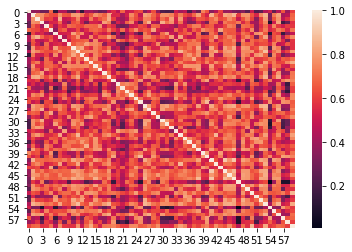

In [25]:
actual_data_clone = actual_data.clone().detach().cpu().numpy()

pairwise_cor_df = pairwise_correlations(actual_data_clone)

import seaborn as sns

sns.heatmap(pairwise_cor_df)

correlates = []
for i in range(2 * D):
    one = np.sum(np.abs(pairwise_cor_df[i, :D]))
    two = np.sum(np.abs(pairwise_cor_df[i, D:2*D]))
    #correlates.append([one, two])
    correlates.append(one > two)
    
# correlation of that feature with the first 30 features and the second 30 features
print(np.sum(correlates[:D]))

print(np.sum(correlates[D:2*D]))

# Now run all of the notebook or just the last part focusing on gumbel vs gradients on truncated (or not) losses

Data is all ready. Now time to feed into into a pretraining-matching Gumbel and joint training Gumbel.

Pre train VAE First

In [26]:
pretrain_vae = VAE(2*D, 100, 20)

pretrain_vae.to(device)
pretrain_vae_optimizer = torch.optim.Adam(pretrain_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

#pretrain_vae_optimizer = torch.optim.SGD(pretrain_vae.parameters(), 
#                                            lr=lr, momentum = 0.9)

In [27]:
for epoch in range(1, n_epochs + 1):
    train(train_data, pretrain_vae, pretrain_vae_optimizer, epoch, batch_size)
    test(test_data, pretrain_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.017113
Train Epoch: 1 [1280/4000 (32%)]	Loss: 40.903053
Train Epoch: 1 [2560/4000 (64%)]	Loss: 39.910145
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.210461
====> Epoch: 1 Average loss: 40.4244
====> Test set loss: 38.9524
Train Epoch: 2 [0/4000 (0%)]	Loss: 38.888924
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.212513
Train Epoch: 2 [2560/4000 (64%)]	Loss: 36.419609
Train Epoch: 2 [3840/4000 (96%)]	Loss: 35.664536
====> Epoch: 2 Average loss: 37.3049
====> Test set loss: 35.4656
Train Epoch: 3 [0/4000 (0%)]	Loss: 35.430317
Train Epoch: 3 [1280/4000 (32%)]	Loss: 34.606815
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.577702
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.209206
====> Epoch: 3 Average loss: 34.6850
====> Test set loss: 34.1042
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.345818
Train Epoch: 4 [1280/4000 (32%)]	Loss: 34.207222
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.563995
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.908337
====> Epoch: 4 Average loss: 33.88

In [28]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(pretrain_vae(test_data)[0], test_data))

Test Loss
tensor(0.5371, device='cuda:0')


Actually pretty good! %35 percent off when wrong

Get 0.49 when nepochs is 50.
Get 0.54 when nepochs is 10.

As a note, if the final layer of the data mapper is not ReLU, this reconstruction is usually on point. When some of the features can be sparse, then this becomes troublesome.

Compare means

In [29]:
train_data.mean(dim = 0)[:D]

tensor([0.0931, 0.3051, 0.1384, 0.2096, 0.2092, 0.2112, 0.1042, 0.2325, 0.0347,
        0.2014, 0.0244, 0.0502, 0.0919, 0.2735, 0.2254, 0.3294, 0.2786, 0.0084,
        0.0338, 0.1001, 0.0849, 0.2512, 0.0048, 0.0257, 0.0015, 0.0874, 0.4764,
        0.3270, 0.2107, 0.2899], device='cuda:0')

In [30]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [31]:
pretrain_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.0908, 0.3028, 0.1420, 0.2037, 0.2054, 0.1995, 0.0929, 0.2195, 0.0451,
        0.2090, 0.0452, 0.0758, 0.0977, 0.2881, 0.2152, 0.3182, 0.2690, 0.0362,
        0.0545, 0.0943, 0.0869, 0.2433, 0.0329, 0.0432, 0.0287, 0.0824, 0.4680,
        0.3353, 0.2242, 0.3056], device='cuda:0', grad_fn=<SliceBackward>)

Compare standard deviations

In [32]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [33]:
pretrain_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0511, 0.0425, 0.0579, 0.0826, 0.0531, 0.0612, 0.0585, 0.0769, 0.0445,
        0.0565, 0.0429, 0.0661, 0.0559, 0.0466, 0.0819, 0.0599, 0.0610, 0.0445,
        0.0506, 0.0552, 0.0604, 0.0814, 0.0368, 0.0407, 0.0333, 0.0639, 0.0274,
        0.0448, 0.0572, 0.0524], device='cuda:0', grad_fn=<SliceBackward>)

In [34]:
pretrain_vae(test_data)[0].std(dim = 0)[D:2*D]

tensor([0.0258, 0.0224, 0.0220, 0.0211, 0.0209, 0.0197, 0.0212, 0.0261, 0.0275,
        0.0209, 0.0215, 0.0206, 0.0221, 0.0222, 0.0201, 0.0218, 0.0185, 0.0206,
        0.0206, 0.0207, 0.0223, 0.0241, 0.0222, 0.0233, 0.0185, 0.0219, 0.0201,
        0.0244, 0.0202, 0.0212], device='cuda:0', grad_fn=<SliceBackward>)

In [35]:
average_std = pretrain_vae(test_data)[0].std(dim = 0)[:D] / test_data.std(dim = 0)[:D]

In [36]:
print(average_std)
print(average_std.mean().item())

tensor([0.2619, 0.1723, 0.2832, 0.3759, 0.2315, 0.3217, 0.3184, 0.3969, 0.4278,
        0.2500, 0.4480, 0.4793, 0.3413, 0.2330, 0.3427, 0.2593, 0.2840, 1.1526,
        0.5259, 0.3186, 0.3528, 0.3536, 0.7277, 0.4432, 2.2260, 0.3402, 0.1694,
        0.1951, 0.2686, 0.2173], device='cuda:0', grad_fn=<DivBackward0>)
0.4239330589771271


Get .8 as the mean when nepoch is 50. Get 0.43 as the mean when nepochs is 10.

Compare values

In [37]:
samp = 45

In [38]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [39]:
pretrain_vae(test_data)[0][samp, :D]

tensor([0.0427, 0.2685, 0.0914, 0.1420, 0.1793, 0.1437, 0.0416, 0.1626, 0.0145,
        0.1706, 0.0122, 0.0227, 0.0351, 0.2458, 0.1958, 0.2595, 0.1965, 0.0051,
        0.0129, 0.0453, 0.0373, 0.1502, 0.0066, 0.0143, 0.0065, 0.0323, 0.4923,
        0.3206, 0.1736, 0.2875], device='cuda:0', grad_fn=<SliceBackward>)

In [40]:
torch.abs(test_data[samp,:D] - pretrain_vae(test_data)[0][samp, :D]).mean()

tensor(0.1399, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
pretrain_vae(test_data)[1][:, :D].mean()

tensor(-0.1136, device='cuda:0', grad_fn=<MeanBackward0>)

In [42]:
torch.exp(pretrain_vae(test_data)[2][:, :D]).mean()

tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)

In [43]:
pretrain_vae.requires_grad_(False)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=60, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (enc_mean): Linear(in_features=100, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=200, out_features=60, bias=True)
    (3): Sigmoid()
  )
)

This looks pretty good.

**Gumbel matching pretrained VAE next**

In [44]:
# let's see how it does here
vae_gumbel_with_pre = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
vae_gumbel_with_pre.to(device)
vae_gumbel_with_pre_optimizer = torch.optim.Adam(vae_gumbel_with_pre.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [45]:
for epoch in range(1, n_epochs + 1):
    train_pre_trained(train_data, vae_gumbel_with_pre, vae_gumbel_with_pre_optimizer, 
                      epoch, pretrain_vae, batch_size)
    test(test_data, vae_gumbel_with_pre, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 131.549118
Train Epoch: 1 [1280/4000 (32%)]	Loss: 124.330681
Train Epoch: 1 [2560/4000 (64%)]	Loss: 135.005920
Train Epoch: 1 [3840/4000 (96%)]	Loss: 113.650055
====> Epoch: 1 Average loss: 127.3878
====> Test set loss: 39.3864
Train Epoch: 2 [0/4000 (0%)]	Loss: 118.468437
Train Epoch: 2 [1280/4000 (32%)]	Loss: 102.895699
Train Epoch: 2 [2560/4000 (64%)]	Loss: 89.528763
Train Epoch: 2 [3840/4000 (96%)]	Loss: 63.037422
====> Epoch: 2 Average loss: 93.6599
====> Test set loss: 36.7838
Train Epoch: 3 [0/4000 (0%)]	Loss: 58.546532
Train Epoch: 3 [1280/4000 (32%)]	Loss: 55.447140
Train Epoch: 3 [2560/4000 (64%)]	Loss: 52.860619
Train Epoch: 3 [3840/4000 (96%)]	Loss: 52.858582
====> Epoch: 3 Average loss: 54.7357
====> Test set loss: 34.8553
Train Epoch: 4 [0/4000 (0%)]	Loss: 52.165733
Train Epoch: 4 [1280/4000 (32%)]	Loss: 51.336662
Train Epoch: 4 [2560/4000 (64%)]	Loss: 54.353249
Train Epoch: 4 [3840/4000 (96%)]	Loss: 49.435875
====> Epoch: 4 Average loss

In [46]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(vae_gumbel_with_pre(test_data)[0], test_data))

Test Loss
tensor(0.5440, device='cuda:0')


Means

In [47]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [48]:
vae_gumbel_with_pre(test_data)[0].mean(dim = 0)[:D]

tensor([0.1020, 0.3086, 0.1487, 0.2077, 0.2110, 0.2140, 0.1047, 0.2268, 0.0470,
        0.2091, 0.0436, 0.0541, 0.1006, 0.2838, 0.2204, 0.3191, 0.2790, 0.0341,
        0.0603, 0.1043, 0.0903, 0.2499, 0.0395, 0.0505, 0.0315, 0.0923, 0.4770,
        0.3366, 0.2215, 0.3029], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [49]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [50]:
vae_gumbel_with_pre(test_data)[0].std(dim = 0)[:D]

tensor([0.0499, 0.0412, 0.0443, 0.0528, 0.0465, 0.0524, 0.0480, 0.0475, 0.0349,
        0.0512, 0.0343, 0.0373, 0.0440, 0.0378, 0.0499, 0.0425, 0.0462, 0.0311,
        0.0426, 0.0485, 0.0475, 0.0410, 0.0337, 0.0418, 0.0296, 0.0469, 0.0205,
        0.0327, 0.0509, 0.0435], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [51]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [52]:
vae_gumbel_with_pre(test_data)[0][samp, :D]

tensor([0.0532, 0.3002, 0.1230, 0.1623, 0.1887, 0.1692, 0.0662, 0.2270, 0.0348,
        0.2394, 0.0198, 0.0278, 0.0650, 0.2875, 0.1846, 0.3385, 0.2906, 0.0103,
        0.0278, 0.0720, 0.0610, 0.2667, 0.0161, 0.0205, 0.0125, 0.0544, 0.4583,
        0.3579, 0.2046, 0.3175], device='cuda:0', grad_fn=<SliceBackward>)

In [53]:
with torch.no_grad():
    w = vae_gumbel_with_pre.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [54]:
# as long as feature index is lesss than 30, then it isn't picking noise
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[ 4, 22, 53, 44, 21, 45, 30, 13, 28, 47, 23, 59, 11, 20,  5],
        [ 7, 33, 19, 43, 31,  8, 45, 14, 54, 40, 17,  6, 46, 52, 20]])

**Joint Train**

In [55]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = 3*z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [56]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 85.017433
Train Epoch: 1 [1280/4000 (32%)]	Loss: 82.511650
Train Epoch: 1 [2560/4000 (64%)]	Loss: 80.430176
Train Epoch: 1 [3840/4000 (96%)]	Loss: 78.637581
====> Epoch: 1 Average loss: 81.5080
====> Test set loss: 79.5400
Train Epoch: 2 [0/4000 (0%)]	Loss: 78.483932
Train Epoch: 2 [1280/4000 (32%)]	Loss: 77.283844
Train Epoch: 2 [2560/4000 (64%)]	Loss: 75.860748
Train Epoch: 2 [3840/4000 (96%)]	Loss: 74.166321
====> Epoch: 2 Average loss: 76.4011
====> Test set loss: 75.6151
Train Epoch: 3 [0/4000 (0%)]	Loss: 74.307861
Train Epoch: 3 [1280/4000 (32%)]	Loss: 72.738884
Train Epoch: 3 [2560/4000 (64%)]	Loss: 71.166466
Train Epoch: 3 [3840/4000 (96%)]	Loss: 69.820045
====> Epoch: 3 Average loss: 72.1045
====> Test set loss: 79.0084
Train Epoch: 4 [0/4000 (0%)]	Loss: 69.653114
Train Epoch: 4 [1280/4000 (32%)]	Loss: 68.887741
Train Epoch: 4 [2560/4000 (64%)]	Loss: 68.468018
Train Epoch: 4 [3840/4000 (96%)]	Loss: 68.222870
====> Epoch: 4 Average loss: 69.09

In [57]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5452, device='cuda:0')


Means

In [58]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [59]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.1084, 0.3106, 0.1507, 0.2148, 0.2177, 0.2183, 0.1170, 0.2396, 0.0622,
        0.2163, 0.0685, 0.0665, 0.1088, 0.2834, 0.2307, 0.3339, 0.2838, 0.0418,
        0.0633, 0.1103, 0.0987, 0.2576, 0.0514, 0.0603, 0.0389, 0.1036, 0.4746,
        0.3356, 0.2194, 0.3010], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [60]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [61]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0464, 0.0338, 0.0517, 0.0409, 0.0508, 0.0430, 0.0502, 0.0492, 0.0442,
        0.0529, 0.0419, 0.0377, 0.0517, 0.0395, 0.0452, 0.0471, 0.0373, 0.0313,
        0.0455, 0.0476, 0.0481, 0.0447, 0.0376, 0.0406, 0.0316, 0.0512, 0.0257,
        0.0347, 0.0461, 0.0375], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [62]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [63]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.1196, 0.3358, 0.1544, 0.1924, 0.2309, 0.2041, 0.1051, 0.2145, 0.0631,
        0.2132, 0.0806, 0.0751, 0.1094, 0.3025, 0.2385, 0.3398, 0.2990, 0.0374,
        0.0522, 0.0936, 0.0918, 0.2571, 0.0353, 0.0578, 0.0360, 0.0880, 0.4327,
        0.3242, 0.2402, 0.2735], device='cuda:0', grad_fn=<SliceBackward>)

In [64]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:2, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.1).cpu()

In [65]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3 * z_size]

tensor([[41, 15, 47, 53, 56, 27, 59, 52, 34, 44, 40, 17,  5, 25, 58],
        [55, 54, 58,  3, 44, 39, 11,  9, 26, 14,  6,  4, 17,  2, 20]])

Joint Training while selecting exactly z_size. Why does it pick the noise variables?

In [66]:
joint_vanilla_vae = VAE(2*D, 100, 20)
joint_vanilla_vae.to(device)

joint_vae_gumbel = VAE_Gumbel(2*D, 100, 20, k = z_size)
joint_vae_gumbel.to(device)

joint_optimizer = torch.optim.Adam(list(joint_vanilla_vae.parameters()) + list(joint_vae_gumbel.parameters()), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [67]:
for epoch in range(1, n_epochs + 1):
    train_joint(train_data, joint_vanilla_vae, joint_vae_gumbel, joint_optimizer, epoch, batch_size)
    test_joint(test_data, joint_vanilla_vae, joint_vae_gumbel, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 85.132713
Train Epoch: 1 [1280/4000 (32%)]	Loss: 82.747704
Train Epoch: 1 [2560/4000 (64%)]	Loss: 80.820213
Train Epoch: 1 [3840/4000 (96%)]	Loss: 79.032799
====> Epoch: 1 Average loss: 81.7773
====> Test set loss: 79.3204
Train Epoch: 2 [0/4000 (0%)]	Loss: 78.711441
Train Epoch: 2 [1280/4000 (32%)]	Loss: 77.595573
Train Epoch: 2 [2560/4000 (64%)]	Loss: 76.076454
Train Epoch: 2 [3840/4000 (96%)]	Loss: 74.498436
====> Epoch: 2 Average loss: 76.7089
====> Test set loss: 75.7804
Train Epoch: 3 [0/4000 (0%)]	Loss: 74.584831
Train Epoch: 3 [1280/4000 (32%)]	Loss: 72.626198
Train Epoch: 3 [2560/4000 (64%)]	Loss: 71.710274
Train Epoch: 3 [3840/4000 (96%)]	Loss: 71.147865
====> Epoch: 3 Average loss: 72.1947
====> Test set loss: 79.4896
Train Epoch: 4 [0/4000 (0%)]	Loss: 69.542427
Train Epoch: 4 [1280/4000 (32%)]	Loss: 68.956856
Train Epoch: 4 [2560/4000 (64%)]	Loss: 68.700424
Train Epoch: 4 [3840/4000 (96%)]	Loss: 68.567574
====> Epoch: 4 Average loss: 69.06

In [68]:
with torch.no_grad():
    print("Test Loss")
    print(F.binary_cross_entropy(joint_vae_gumbel(test_data)[0], test_data))

Test Loss
tensor(0.5457, device='cuda:0')


Means

In [69]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [70]:
joint_vae_gumbel(test_data)[0].mean(dim = 0)[:D]

tensor([0.1085, 0.3148, 0.1535, 0.2221, 0.2227, 0.2211, 0.1210, 0.2454, 0.0646,
        0.2156, 0.0598, 0.0761, 0.1110, 0.2805, 0.2432, 0.3426, 0.2877, 0.0537,
        0.0605, 0.1161, 0.1068, 0.2657, 0.0438, 0.0600, 0.0423, 0.1058, 0.4768,
        0.3289, 0.2236, 0.2947], device='cuda:0', grad_fn=<SliceBackward>)

Deviations

In [71]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [72]:
joint_vae_gumbel(test_data)[0].std(dim = 0)[:D]

tensor([0.0516, 0.0436, 0.0529, 0.0474, 0.0487, 0.0477, 0.0530, 0.0501, 0.0412,
        0.0549, 0.0431, 0.0489, 0.0586, 0.0425, 0.0525, 0.0381, 0.0485, 0.0412,
        0.0398, 0.0498, 0.0487, 0.0516, 0.0370, 0.0408, 0.0372, 0.0462, 0.0228,
        0.0315, 0.0514, 0.0380], device='cuda:0', grad_fn=<SliceBackward>)

Values

In [73]:
test_data[samp,:D]

tensor([0.0000, 0.5286, 0.0000, 0.0231, 0.6963, 0.3966, 0.0103, 0.2939, 0.0000,
        0.3152, 0.0000, 0.0000, 0.0000, 0.0617, 0.4150, 0.6262, 0.2110, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6829, 0.0000, 0.0000, 0.0000, 0.0000, 0.3516,
        0.0000, 0.6491, 0.4560], device='cuda:0')

In [74]:
joint_vae_gumbel(test_data)[0][samp, :D]

tensor([0.0646, 0.3793, 0.1757, 0.1760, 0.2028, 0.2190, 0.1176, 0.2173, 0.0418,
        0.2300, 0.0466, 0.0532, 0.1153, 0.2583, 0.2227, 0.3207, 0.2624, 0.0559,
        0.0566, 0.1064, 0.0933, 0.2606, 0.0267, 0.0469, 0.0340, 0.0968, 0.4922,
        0.3316, 0.2492, 0.3012], device='cuda:0', grad_fn=<SliceBackward>)

In [75]:
with torch.no_grad():
    w = joint_vae_gumbel.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=z_size, t=0.1).cpu()

In [76]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :z_size]

tensor([[57, 43, 34, 23, 20],
        [14, 58, 10, 31, 16],
        [18, 27, 36, 58, 53],
        [33, 55, 29, 14, 18],
        [14,  4, 19, 22, 54],
        [11,  9, 57,  1, 48],
        [ 8,  9, 28, 49, 27],
        [16, 52, 21,  7, 22],
        [20,  4,  6, 16, 14],
        [54,  4, 13, 33, 38]])

Matching pre trained is actually better here than joint training.
The gumbel trick greatly reduces the ability to make predictions. 
Notice that the standard deviations are not as high as in the original data. Not being able to use a model looking at the full data as an anchor definitely hurts.

# Calculation of Loss only over select features
What happens if we limit the calculation of the loss to just the first few non-noisy stuff?

Not doing joint training here because the calculation of loss is hidden inside utils and cannot modify the indexing so easily.

In [77]:
def train_truncated_with_gradients(df, model, optimizer, epoch, batch_size, Dim):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    gradients = torch.zeros(df.shape[1]).to(device)
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone().to(device)
        
        
        # need to do this twice because deriative with respect to input not implemented in BCE
        # so need to switch them up
        optimizer.zero_grad()
        batch_data.requires_grad_(True)
        mu_x, mu_latent, logvar_latent = model(batch_data)
        # why clone detach here?
        # still want gradient with respect to input, but BCE gradient with respect to target is not defined
        # plus we only want to see how input affects mu_x, not the target
        loss = loss_function_per_autoencoder(batch_data[:, :Dim].clone().detach(), mu_x[:, :Dim], 
                                             mu_latent, logvar_latent) 
        loss.backward(retain_graph=True)

        with torch.no_grad():
            gradients += torch.sqrt(batch_data.grad ** 2).sum(dim = 0)
        # no step
        
        optimizer.zero_grad()
        # do not calculate with respect to 
        batch_data.requires_grad_(False)
        mu_x.requires_grad_(True)
        loss = loss_function_per_autoencoder(batch_data[:, :Dim], mu_x[:, :Dim], mu_latent, logvar_latent) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    return gradients
    
# match pre trained model
def train_pre_trained_truncated(df, model, optimizer, epoch, pretrained_model, batch_size, D):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone()
        
        batch_data.requires_grad_(True)
        
        optimizer.zero_grad()
        mu_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data[:, :D], mu_x[:, :D], mu_latent, logvar_latent)
        loss += 10*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [78]:
global_t = 0.1

In [79]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

Just train a gumbel without matching or joint training to see

In [80]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.603951
Train Epoch: 1 [1280/4000 (32%)]	Loss: 19.685429
Train Epoch: 1 [2560/4000 (64%)]	Loss: 18.728348
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.104939
====> Epoch: 1 Average loss: 19.2062
====> Test set loss: 38.8664
Train Epoch: 2 [0/4000 (0%)]	Loss: 17.837116
Train Epoch: 2 [1280/4000 (32%)]	Loss: 16.836750
Train Epoch: 2 [2560/4000 (64%)]	Loss: 15.432273
Train Epoch: 2 [3840/4000 (96%)]	Loss: 14.460063
====> Epoch: 2 Average loss: 16.1168
====> Test set loss: 36.0047
Train Epoch: 3 [0/4000 (0%)]	Loss: 14.345492
Train Epoch: 3 [1280/4000 (32%)]	Loss: 13.826084
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.376080
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.494702
====> Epoch: 3 Average loss: 13.7539
====> Test set loss: 34.7974
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.203712
Train Epoch: 4 [1280/4000 (32%)]	Loss: 12.809281
Train Epoch: 4 [2560/4000 (64%)]	Loss: 12.940740
Train Epoch: 4 [3840/4000 (96%)]	Loss: 13.150167
====> Epoch: 4 Average loss: 13.04

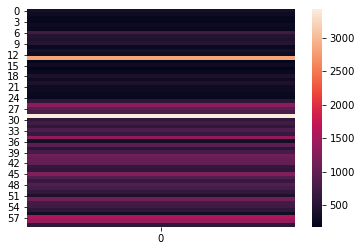

In [81]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [82]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [83]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1197, 0.3199, 0.1576, 0.2190, 0.2233, 0.2228, 0.1175, 0.2402, 0.0606,
        0.2235, 0.0555, 0.0650, 0.1165, 0.2942, 0.2304, 0.3309, 0.2863, 0.0494,
        0.0591, 0.1237, 0.1024, 0.2569, 0.0356, 0.0550, 0.0368, 0.1075, 0.4738,
        0.3436, 0.2326, 0.3095], device='cuda:0', grad_fn=<SliceBackward>)

In [84]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [85]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0592, 0.0476, 0.0446, 0.0566, 0.0534, 0.0496, 0.0506, 0.0513, 0.0431,
        0.0470, 0.0440, 0.0414, 0.0523, 0.0468, 0.0503, 0.0449, 0.0419, 0.0393,
        0.0394, 0.0610, 0.0555, 0.0465, 0.0278, 0.0389, 0.0334, 0.0551, 0.0219,
        0.0348, 0.0503, 0.0382], device='cuda:0', grad_fn=<SliceBackward>)

In [86]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=global_t).cpu()

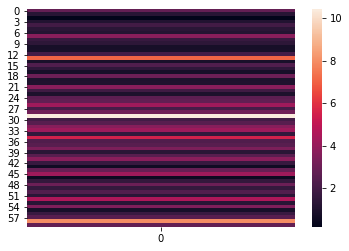

In [87]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [88]:
subset_indices

tensor([[2.2033e-10, 4.1385e-06, 7.8867e-05, 5.0184e-01, 6.0649e-01, 3.1646e-05,
         1.5820e-09, 8.3187e-04, 3.8480e-01, 4.2356e-07, 2.3095e-06, 5.2126e-01,
         3.0055e-14, 8.4843e-01, 9.5906e-04, 5.5669e-12, 2.2515e-05, 1.2489e-01,
         2.5157e-01, 3.3648e-04, 2.0704e-01, 3.6579e-02, 1.0065e+00, 2.6060e-07,
         6.3274e-01, 2.6728e-02, 9.9013e-05, 1.3258e-03, 1.8280e-01, 9.9984e-01,
         3.4750e-01, 3.2942e-01, 5.6898e-06, 7.7961e-01, 1.7808e-09, 2.0934e-05,
         9.0837e-01, 1.6714e-05, 1.1975e+00, 1.7126e-03, 1.6156e-18, 5.2887e-01,
         4.3101e-07, 3.6453e-24, 1.0516e-04, 1.1478e+00, 9.6168e-02, 2.9548e-01,
         1.8074e-16, 7.8081e-09, 2.5626e-01, 2.1622e-02, 7.6024e-01, 1.4109e-03,
         7.8614e-01, 8.5735e-06, 1.8741e-09, 8.9354e-16, 1.1745e+00, 3.2099e-02],
        [1.9353e-08, 1.1223e-03, 1.3260e-04, 1.4142e-08, 3.3147e-05, 8.2445e-08,
         3.7810e-03, 3.8130e-01, 4.6551e-02, 5.7176e-06, 6.6600e-01, 2.8194e-04,
         8.5353e-01, 8.4648

In [89]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[38, 58, 45, 22, 29, 36, 13, 54, 33, 52, 24,  4, 41, 11,  3],
        [58, 59, 21, 51, 29, 12, 13, 55, 54, 10, 48, 52, 35, 23, 45],
        [37, 29, 35,  8, 41, 44,  1, 25,  0, 13, 42, 53, 54, 16, 18],
        [48, 13, 58, 25, 52, 29, 41, 31, 37, 54, 15, 26,  6, 43,  9],
        [49, 50, 35,  5, 24,  7, 29, 52, 14, 34, 59, 58,  3, 37,  6],
        [32, 52, 40, 29, 19,  0, 28, 13, 38,  4,  9, 21, 44, 41, 34],
        [29, 21,  7, 33,  0, 18, 57, 59, 58, 38, 45, 13, 17, 25, 36],
        [27, 13, 29, 35, 45, 26, 57, 56, 58, 41, 15, 50, 28, 54, 17],
        [31, 48, 35, 26, 39, 58, 33, 15, 38, 16, 32, 29, 36, 18,  4],
        [58, 30, 44, 47, 40, 29, 45, 32, 24, 13,  7, 57, 28, 26, 25]])

In [90]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(69.6819)
tensor(80.3181)


In [91]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(72, device='cuda:0')

What happens if you run it on all the data? And not truncate the loss to the first D features?

In [92]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [93]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vae_gumbel_truncated, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 42.418247
Train Epoch: 1 [1280/4000 (32%)]	Loss: 41.338345
Train Epoch: 1 [2560/4000 (64%)]	Loss: 40.549778
Train Epoch: 1 [3840/4000 (96%)]	Loss: 39.576008
====> Epoch: 1 Average loss: 40.8841
====> Test set loss: 39.4801
Train Epoch: 2 [0/4000 (0%)]	Loss: 39.528938
Train Epoch: 2 [1280/4000 (32%)]	Loss: 38.531277
Train Epoch: 2 [2560/4000 (64%)]	Loss: 37.746029
Train Epoch: 2 [3840/4000 (96%)]	Loss: 36.861862
====> Epoch: 2 Average loss: 38.1238
====> Test set loss: 36.3072
Train Epoch: 3 [0/4000 (0%)]	Loss: 36.407623
Train Epoch: 3 [1280/4000 (32%)]	Loss: 35.568157
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.785275
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.594353
====> Epoch: 3 Average loss: 35.2023
====> Test set loss: 34.3914
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.546940
Train Epoch: 4 [1280/4000 (32%)]	Loss: 34.047134
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.973038
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.639668
====> Epoch: 4 Average loss: 34.10

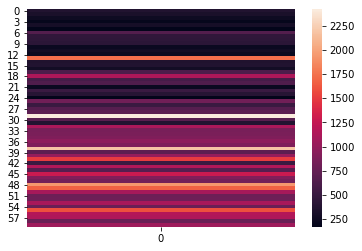

In [94]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [95]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [96]:
vae_gumbel_truncated(test_data)[0].mean(dim = 0)[:D]

tensor([0.1031, 0.3013, 0.1440, 0.2081, 0.2162, 0.2130, 0.1098, 0.2335, 0.0582,
        0.2091, 0.0413, 0.0709, 0.1091, 0.2866, 0.2203, 0.3276, 0.2797, 0.0362,
        0.0529, 0.1051, 0.0938, 0.2499, 0.0342, 0.0509, 0.0344, 0.0915, 0.4767,
        0.3331, 0.2205, 0.3030], device='cuda:0', grad_fn=<SliceBackward>)

In [97]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [98]:
vae_gumbel_truncated(test_data)[0].std(dim = 0)[:D]

tensor([0.0524, 0.0358, 0.0503, 0.0537, 0.0519, 0.0541, 0.0518, 0.0574, 0.0445,
        0.0418, 0.0344, 0.0479, 0.0553, 0.0483, 0.0488, 0.0356, 0.0480, 0.0328,
        0.0383, 0.0488, 0.0518, 0.0544, 0.0330, 0.0376, 0.0340, 0.0490, 0.0197,
        0.0439, 0.0497, 0.0478], device='cuda:0', grad_fn=<SliceBackward>)

In [99]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=global_t).cpu()

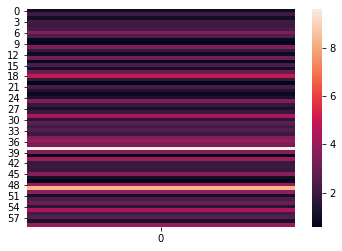

In [100]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [101]:
subset_indices

tensor([[2.1957e-03, 4.1217e-08, 1.3116e-07, 5.3050e-01, 2.1658e-01, 6.4857e-13,
         9.6019e-05, 1.3639e-01, 3.7742e-18, 5.1030e-07, 2.4047e-08, 2.4734e-02,
         1.7548e-06, 6.1487e-04, 8.2126e-11, 9.2167e-01, 8.4010e-16, 1.6186e-03,
         1.2535e-13, 1.1427e+00, 7.3616e-09, 5.6328e-01, 2.4434e-04, 6.1465e-14,
         1.0250e-04, 2.3740e-03, 6.9621e-01, 9.4910e-07, 7.7099e-02, 1.3132e+00,
         7.2230e-08, 2.7760e-09, 7.9652e-01, 2.7674e-03, 2.1156e-01, 1.6934e-01,
         8.6480e-05, 2.4194e-02, 1.1694e+00, 8.2971e-01, 5.5229e-04, 4.1136e-01,
         1.7791e-07, 1.4301e-02, 1.7501e-06, 1.4520e+00, 1.7154e-01, 2.0627e-03,
         1.2279e-06, 9.7056e-01, 2.5661e-01, 9.2322e-04, 5.4273e-04, 3.9920e-03,
         3.3534e-05, 4.0421e-03, 9.9279e-01, 1.1448e+00, 2.0802e-09, 7.4062e-01],
        [1.0324e-09, 2.8821e-01, 8.9008e-01, 8.3829e-02, 1.4763e-12, 6.7373e-05,
         6.5204e-01, 9.5666e-04, 4.2889e-03, 9.9894e-02, 6.9019e-04, 7.6299e-07,
         6.6169e-01, 2.8862

In [102]:
torch.argsort(subset_indices, dim = 1, descending = True)[:, :3*z_size]

tensor([[45, 29, 38, 57, 19, 56, 49, 15, 39, 32, 59, 26, 21,  3, 41],
        [38, 25, 28, 43, 33,  2, 18, 44, 59, 12, 31,  6, 45, 17, 26],
        [ 6, 35, 17, 55,  5, 39, 38, 50, 10, 36,  1, 51, 49, 58, 46],
        [59, 38, 13, 36, 16, 18,  5,  7, 10, 37, 25, 54, 41, 35, 24],
        [49, 22, 50, 48, 25, 37, 36,  7, 44, 41, 56, 45, 19,  0, 38],
        [59, 10, 18,  3, 49, 23, 35, 52, 43, 15, 14, 53, 38,  9, 26],
        [21, 38, 52, 31, 48, 49, 30, 15,  8, 58, 33, 36, 34, 51, 40],
        [55, 29, 49,  1, 33,  4, 42, 41, 27, 37, 32, 57, 20, 25, 53],
        [38, 49, 11,  6, 55, 18, 48,  4, 50, 10, 42, 54, 24, 53, 41],
        [13, 49, 34, 35, 39, 38, 50, 41, 36, 17, 29, 55,  7, 45, 57]])

In [103]:
print(subset_indices[:, :D].sum())

print(subset_indices[:, D:2*D].sum())

tensor(60.4515)
tensor(89.5485)


In [104]:
torch.sum(w.argsort(descending= True)[:, :3*z_size] < 30)

tensor(59, device='cuda:0')

# How does a normal VAE do?

Trying to reconstruct first 30 features only

In [105]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [106]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 21.047403
Train Epoch: 1 [1280/4000 (32%)]	Loss: 20.051741
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.108959
Train Epoch: 1 [3840/4000 (96%)]	Loss: 18.373169
====> Epoch: 1 Average loss: 19.6401
====> Test set loss: 39.1637
Train Epoch: 2 [0/4000 (0%)]	Loss: 18.304516
Train Epoch: 2 [1280/4000 (32%)]	Loss: 17.499392
Train Epoch: 2 [2560/4000 (64%)]	Loss: 15.739826
Train Epoch: 2 [3840/4000 (96%)]	Loss: 14.872540
====> Epoch: 2 Average loss: 16.4072
====> Test set loss: 35.9770
Train Epoch: 3 [0/4000 (0%)]	Loss: 14.670109
Train Epoch: 3 [1280/4000 (32%)]	Loss: 13.483430
Train Epoch: 3 [2560/4000 (64%)]	Loss: 13.659747
Train Epoch: 3 [3840/4000 (96%)]	Loss: 13.333156
====> Epoch: 3 Average loss: 13.8732
====> Test set loss: 34.7371
Train Epoch: 4 [0/4000 (0%)]	Loss: 13.719816
Train Epoch: 4 [1280/4000 (32%)]	Loss: 13.096689
Train Epoch: 4 [2560/4000 (64%)]	Loss: 12.592405
Train Epoch: 4 [3840/4000 (96%)]	Loss: 12.849434
====> Epoch: 4 Average loss: 13.09

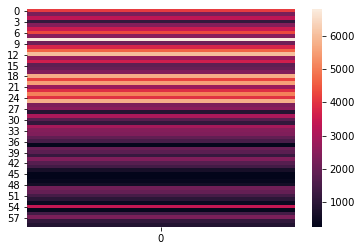

In [107]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [108]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [109]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.0907, 0.3023, 0.1410, 0.2149, 0.2137, 0.2062, 0.1085, 0.2327, 0.0502,
        0.2035, 0.0400, 0.0680, 0.0983, 0.2818, 0.2356, 0.3361, 0.2778, 0.0358,
        0.0495, 0.0993, 0.0958, 0.2498, 0.0346, 0.0419, 0.0339, 0.0942, 0.4815,
        0.3253, 0.2162, 0.3015], device='cuda:0', grad_fn=<SliceBackward>)

In [110]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [111]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0524, 0.0486, 0.0674, 0.0889, 0.0553, 0.0622, 0.0800, 0.1079, 0.0507,
        0.0683, 0.0409, 0.0636, 0.0587, 0.1104, 0.1528, 0.1564, 0.0564, 0.0411,
        0.0452, 0.0599, 0.0753, 0.1166, 0.0429, 0.0395, 0.0364, 0.0894, 0.0607,
        0.1335, 0.0650, 0.1296], device='cuda:0', grad_fn=<SliceBackward>)

Looking at all dimensions

In [112]:
vanilla_vae = VAE(2*D, 100, 20)

vanilla_vae.to(device)
vanilla_vae_optimizer = torch.optim.Adam(vanilla_vae.parameters(), 
                                            lr=lr,
                                            betas = (b1,b2))

In [113]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vanilla_vae, 
                                         vanilla_vae_optimizer, epoch, batch_size, Dim = 2*D)
    if epoch > 5:
        gradients += grads
    test(test_data, vanilla_vae, epoch, batch_size)

Train Epoch: 1 [0/4000 (0%)]	Loss: 41.617455
Train Epoch: 1 [1280/4000 (32%)]	Loss: 40.671642
Train Epoch: 1 [2560/4000 (64%)]	Loss: 39.780693
Train Epoch: 1 [3840/4000 (96%)]	Loss: 38.756336
====> Epoch: 1 Average loss: 40.2093
====> Test set loss: 38.7997
Train Epoch: 2 [0/4000 (0%)]	Loss: 38.768871
Train Epoch: 2 [1280/4000 (32%)]	Loss: 37.725109
Train Epoch: 2 [2560/4000 (64%)]	Loss: 36.658443
Train Epoch: 2 [3840/4000 (96%)]	Loss: 35.481888
====> Epoch: 2 Average loss: 37.2105
====> Test set loss: 35.5368
Train Epoch: 3 [0/4000 (0%)]	Loss: 35.653290
Train Epoch: 3 [1280/4000 (32%)]	Loss: 34.811913
Train Epoch: 3 [2560/4000 (64%)]	Loss: 34.198151
Train Epoch: 3 [3840/4000 (96%)]	Loss: 34.466022
====> Epoch: 3 Average loss: 34.7453
====> Test set loss: 34.1490
Train Epoch: 4 [0/4000 (0%)]	Loss: 34.484718
Train Epoch: 4 [1280/4000 (32%)]	Loss: 33.795086
Train Epoch: 4 [2560/4000 (64%)]	Loss: 33.455265
Train Epoch: 4 [3840/4000 (96%)]	Loss: 33.601940
====> Epoch: 4 Average loss: 33.89

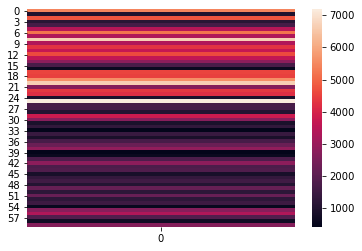

In [114]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [115]:
test_data.mean(dim = 0)[:D]

tensor([0.0978, 0.3031, 0.1394, 0.2099, 0.2063, 0.2098, 0.1076, 0.2316, 0.0298,
        0.1968, 0.0261, 0.0561, 0.0848, 0.2727, 0.2320, 0.3355, 0.2739, 0.0056,
        0.0301, 0.0953, 0.0889, 0.2483, 0.0063, 0.0231, 0.0009, 0.0924, 0.4782,
        0.3251, 0.2092, 0.2881], device='cuda:0')

In [116]:
vanilla_vae(test_data)[0].mean(dim = 0)[:D]

tensor([0.1032, 0.3043, 0.1522, 0.2151, 0.2293, 0.2127, 0.1030, 0.2354, 0.0451,
        0.2218, 0.0566, 0.0798, 0.1089, 0.2916, 0.2219, 0.3349, 0.2817, 0.0399,
        0.0551, 0.1105, 0.1000, 0.2476, 0.0449, 0.0612, 0.0362, 0.0924, 0.4787,
        0.3333, 0.2307, 0.3121], device='cuda:0', grad_fn=<SliceBackward>)

In [117]:
test_data.std(dim = 0)[:D]

tensor([0.1913, 0.2338, 0.2076, 0.2199, 0.2306, 0.1890, 0.1805, 0.1945, 0.1051,
        0.2321, 0.0976, 0.1389, 0.1652, 0.1922, 0.2341, 0.2330, 0.2048, 0.0390,
        0.0929, 0.1692, 0.1755, 0.2236, 0.0499, 0.0923, 0.0152, 0.1863, 0.1593,
        0.2244, 0.2096, 0.2350], device='cuda:0')

In [118]:
vanilla_vae(test_data)[0].std(dim = 0)[:D]

tensor([0.0562, 0.0421, 0.0579, 0.0828, 0.0674, 0.0622, 0.0711, 0.0935, 0.0432,
        0.0555, 0.0569, 0.0655, 0.0594, 0.0694, 0.0859, 0.0905, 0.0578, 0.0428,
        0.0459, 0.0714, 0.0772, 0.0680, 0.0486, 0.0534, 0.0423, 0.0767, 0.0385,
        0.0688, 0.0497, 0.0778], device='cuda:0', grad_fn=<SliceBackward>)

The gradients are a few epochs are good for selecting of features as the Gumbel trick. Maybe even better.
In fact, a Vanilla VAE is just as good.